In [ ]:
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave,imshow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory('/content/drive/MyDrive/images',target_size=(256, 256),class_mode=None)

Found 84 images belonging to 1 classes.


In [ ]:
X =[]
Y =[]
for img in train[0]:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128)

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(32, 256, 256)
(32, 256, 256, 2)


In [ ]:
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)

(32, 256, 256, 1)
(32, 256, 256, 2)


In [ ]:
class Encoder(tf.keras.Model):

  def __init__(self):
    super(Encoder,self).__init__(name='Encoder')
    self.conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256,256,1))
    self.conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')
    self.conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)
    self.conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')
    self.conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)
    self.conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')
    self.conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')
    self.conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')
  
  def call(self,input_tensor):
    x = self.conv1(input_tensor)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.conv8(x)
    return x

In [ ]:
class Decoder(tf.keras.Model):

  def __init__(self):
    super(Decoder,self).__init__(name='Decoder')
    self.conv1 = Conv2D(128, (3,3), activation='relu', padding='same')
    self.up1 = UpSampling2D((2, 2))
    self.conv2 = Conv2D(64, (3,3), activation='relu', padding='same')
    self.up2 = UpSampling2D((2, 2))
    self.conv3 = Conv2D(32, (3,3), activation='relu', padding='same')
    self.conv4 = Conv2D(16, (3,3), activation='relu', padding='same')
    self.conv5 = Conv2D(2, (3,3), activation='tanh', padding='same')
    self.up3 = UpSampling2D((2, 2))
  
  def call(self,input_tensor):
    x = self.conv1(input_tensor)
    x = self.up1(x)
    x = self.conv2(x)
    x = self.up2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.up3(x)
    return x

In [ ]:
class Autoencoder(tf.keras.Model):
  
  def __init__(self):
    super(Autoencoder,self).__init__(name='Autoencoder')
    self.encoder = Encoder()
    self.decoder = Decoder()
  
  def call(self,input_tensor):
    x = self.encoder(input_tensor)
    x = self.decoder(x)
    return x

In [ ]:
model = Autoencoder()

In [ ]:
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.build(input_shape=(None,256,256,1))

In [ ]:
model.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder (Encoder)            multiple                  5827200   
_________________________________________________________________
Decoder (Decoder)            multiple                  392210    
Total params: 6,219,410
Trainable params: 6,219,410
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X,Y,validation_split=.1,epochs=500)

Epoch 1/500
1/1 [==============================] - 1s 821ms/step - loss: 0.0018 - accuracy: 0.9226 - val_loss: 0.0093 - val_accuracy: 0.8254
Epoch 2/500
1/1 [==============================] - 1s 695ms/step - loss: 0.0018 - accuracy: 0.9219 - val_loss: 0.0093 - val_accuracy: 0.8254
Epoch 3/500
1/1 [==============================] - 1s 691ms/step - loss: 0.0018 - accuracy: 0.9224 - val_loss: 0.0093 - val_accuracy: 0.8256
Epoch 4/500
1/1 [==============================] - 1s 691ms/step - loss: 0.0018 - accuracy: 0.9227 - val_loss: 0.0093 - val_accuracy: 0.8249
Epoch 5/500
1/1 [==============================] - 1s 688ms/step - loss: 0.0018 - accuracy: 0.9220 - val_loss: 0.0094 - val_accuracy: 0.8254
Epoch 6/500
1/1 [==============================] - 1s 693ms/step - loss: 0.0018 - accuracy: 0.9230 - val_loss: 0.0093 - val_accuracy: 0.8250
Epoch 7/500
1/1 [==============================] - 1s 689ms/step - loss: 0.0018 - accuracy: 0.9217 - val_loss: 0.0094 - val_accuracy: 0.8256
Epoch 8/500
1

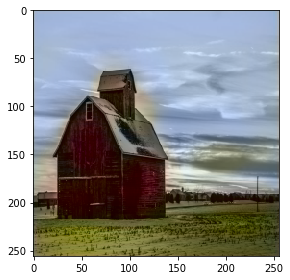

In [ ]:
img1_color=[]
img1=img_to_array(load_img('/content/b2.jpg'))
img1 = resize(img1 ,(256,256))
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = model.predict(img1_color)
output1 = output1*128

result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
imshow(lab2rgb(result))
#imsave('result.jpg',lab2rgb(result))